In [1]:
import pickle
import mne

data_save = r"C:\Users\user\Desktop\MasterThesis\opm-thesis\data\data_nottingham_preprocessed\epochs"
frequency_band = [
    "alpha",
    "beta",
    "low_gamma",
    "low_mid_gamma",
    "mid_gamma",
    "high_gamma",
    "all_gamma",
]
decimate = True

with open(data_save + "\\hilbert_" + frequency_band[0] + "_all_epochs.pkl", "rb") as f:
  alpha = pickle.load(f)

with open(data_save + "\\hilbert_" + frequency_band[2] + "_all_epochs.pkl", "rb") as f:
  low_gamma = pickle.load(f)

with open(data_save + "\\all_epochs.pkl", "rb") as f:
  epochs = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\user\\Desktop\\MasterThesis\\opm-thesis\\data\\data_nottingham_preprocessed\\epochs\\hilbert_alpha_all_epochs.pkl'

In [ ]:
# Compute Pearson correlation coefficient between alpha and low gamma
import scipy.stats as stats

corr, _ = stats.pearsonr(alpha.get_data()[:, 0, 0], low_gamma.get_data()[:, 0, 0])
picks = mne.pick_types(alpha.info, meg=True, exclude="bads")


ValueError: This function does not support complex data

In [ ]:
from mne.decoding import Scaler

scaler = Scaler(scalings='mean')
alpha_data = scaler.fit_transform(alpha.get_data())[:, picks, :]
low_gamma_data = scaler.fit_transform(low_gamma.get_data())[:, picks, :]
epochs = scaler.fit_transform(epochs.get_data())[:, picks, :]

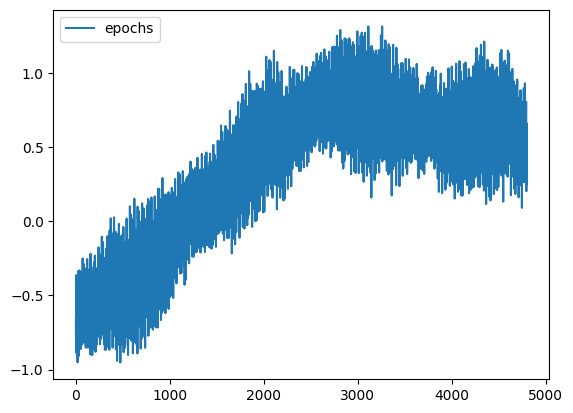

In [ ]:
from matplotlib import pyplot as plt

# Plot both signals
# plt.plot(low_gamma_data[1, 25, :], label="low gamma")
plt.plot(epochs[1, 25, :], label="epochs")
plt.legend()
plt.show()


In [ ]:
acq_times = ["155445", "160513", "161344", "163001"]
low_gamma = dict({"l_freq": 30, "h_freq": 60})

frequencies = { 
    "low_gamma": low_gamma,
}
for key, frequency_params in frequencies.items():
    preprocessed_epochs = list()
    for i in range(4):
        preprocessing = pickle.load(
            open(data_save + "\\preprocessing_" + acq_times[i] + ".pkl", "rb")
        )
        raw_filtered = preprocessing.apply_filters(
            preprocessing.raw, frequency_params, notch_filter=False,
        )
        picks = mne.pick_types(raw_filtered.info, meg="mag", exclude="bads")
        hilbert_transformed = raw_filtered.copy().apply_hilbert(picks=picks)
        hilbert_epochs = preprocessing.create_epochs(hilbert_transformed)

## Finding best channels

In [ ]:
import matplotlib.pyplot as plt

acq_times = ["155445", "160513", "161344", "163001"]
DATA_DIR = (
    r"/Users/martin.iniguez/Desktop/master_thesis/"
    r"opm-thesis/data/data_nottingham_preprocessed"
)
with open(DATA_DIR + "/preprocessing_" + acq_times[3] + ".pkl", "rb") as f:
    preprocessing = pickle.load(f)
  
raw = preprocessing.raw

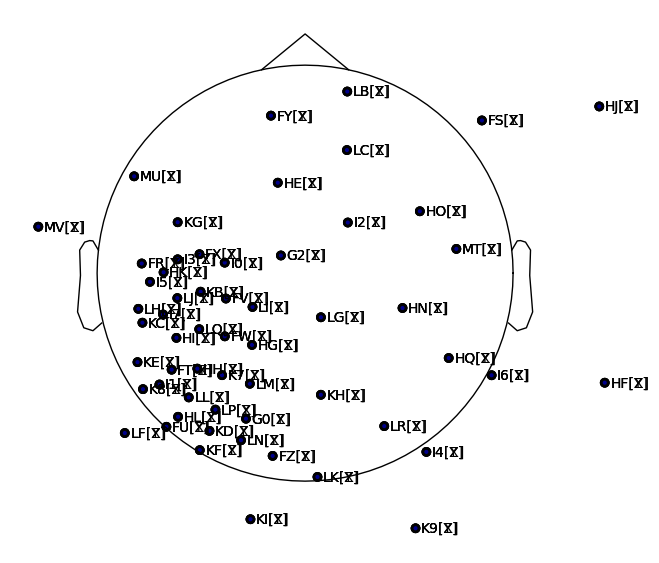

In [ ]:
raw.plot_sensors(kind="topomap", show_names=True)
plt.show()

In [ ]:
import numpy as np

num = 27
# Extract sensor positions and names of channels with valid locations
sensor_positions = mne.find_layout(raw.info).pos
sensor_names_with_pos = np.array(mne.find_layout(raw.info).names)

# Filter sensors that contain '[X]' in their name
mask = np.array(['[X]' in name for name in sensor_names_with_pos])
sensor_positions_X = sensor_positions[mask]
sensor_names_with_pos_X = sensor_names_with_pos[mask]

# Find index of C3
c3_idx = np.where(sensor_names_with_pos_X == 'LQ[X]')[0][0]

# Calculate Euclidean distance from C3 to all sensors
distances = np.linalg.norm(sensor_positions_X - sensor_positions_X[c3_idx], axis=1)

# Find the 25 closest sensors
closest_sensors_idx = np.argsort(distances)[:num]

# Get the names of the 25 closest sensors
closest_sensors_names = sensor_names_with_pos_X[closest_sensors_idx] 
names_y = [name[:-3] + "[Y]" for name in closest_sensors_names]
names_z = [name[:-3] + "[Z]" for name in closest_sensors_names]
closest_sensors_names = np.concatenate((closest_sensors_names, names_y, names_z))

print(f"{num} closest sensors to C3 are:", closest_sensors_names)


27 closest sensors to C3 are: ['LQ[X]' 'HI[X]' 'FW[X]' 'I7[X]' 'LJ[X]' 'FV[X]' 'KB[X]' 'HH[X]' 'HG[X]'
 'KC[X]' 'FT[X]' 'LI[X]' 'K7[X]' 'LH[X]' 'KE[X]' 'I5[X]' 'HK[X]' 'I1[X]'
 'LM[X]' 'LL[X]' 'I0[X]' 'I3[X]' 'K8[X]' 'FX[X]' 'FR[X]' 'LP[X]' 'HL[X]'
 'LQ[Y]' 'HI[Y]' 'FW[Y]' 'I7[Y]' 'LJ[Y]' 'FV[Y]' 'KB[Y]' 'HH[Y]' 'HG[Y]'
 'KC[Y]' 'FT[Y]' 'LI[Y]' 'K7[Y]' 'LH[Y]' 'KE[Y]' 'I5[Y]' 'HK[Y]' 'I1[Y]'
 'LM[Y]' 'LL[Y]' 'I0[Y]' 'I3[Y]' 'K8[Y]' 'FX[Y]' 'FR[Y]' 'LP[Y]' 'HL[Y]'
 'LQ[Z]' 'HI[Z]' 'FW[Z]' 'I7[Z]' 'LJ[Z]' 'FV[Z]' 'KB[Z]' 'HH[Z]' 'HG[Z]'
 'KC[Z]' 'FT[Z]' 'LI[Z]' 'K7[Z]' 'LH[Z]' 'KE[Z]' 'I5[Z]' 'HK[Z]' 'I1[Z]'
 'LM[Z]' 'LL[Z]' 'I0[Z]' 'I3[Z]' 'K8[Z]' 'FX[Z]' 'FR[Z]' 'LP[Z]' 'HL[Z]']


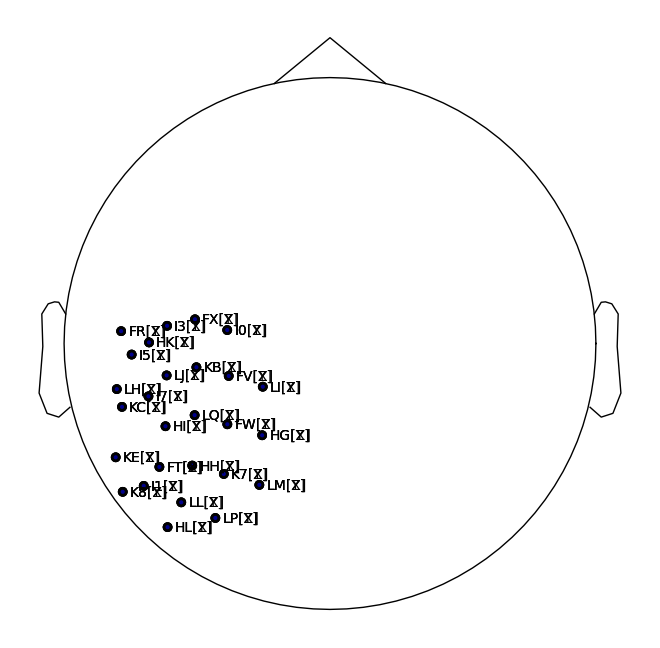

In [ ]:
# Create new raw only with the 25 closest sensors
raw_num = raw.copy().pick(closest_sensors_names)
raw_num.plot_sensors(kind="topomap", show_names=True)
plt.show()

In [ ]:
import mne
import numpy as np

def detect_bad_channels_by_zscore(raw: mne.io.Raw, coordinate: str, zscore_threshold: float = 2.0) -> list:
    """
    Detect bad channels based on z-score of the channel's data for specified coordinate channels.

    Parameters:
    - raw: mne.io.Raw
        The raw data.
    - coordinate: str
        The coordinate system to filter channels by. Should be one of ['X', 'Y', 'Z'].
    - zscore_threshold: float, optional
        Channels with a z-score (based on peak-to-peak amplitude) greater than 
        this threshold will be marked as bad. Defaults to 3.0.

    :return: List of channel names marked as bad.
    :rtype: list
    """
    
    # Ensure the coordinate is one of ['X', 'Y', 'Z']
    if coordinate not in ['X', 'Y', 'Z']:
        raise ValueError("Invalid coordinate. Should be one of ['X', 'Y', 'Z']")

    # Filter channels by coordinate
    ch_names = np.array(raw.ch_names)
    mask = np.array([f"[{coordinate}]" in ch_name for ch_name in ch_names])
    selected_ch_names = ch_names[mask]
    selected_data = raw._data[mask, :]

    # Compute peak-to-peak amplitude for selected channels
    ptp_values = np.ptp(selected_data, axis=1)
    
    # Compute z-scores for each channel
    z_scores = (ptp_values - np.mean(ptp_values)) / np.std(ptp_values)
    
    # Detect channels with z-scores greater than the threshold
    bad_channels = np.where(np.abs(z_scores) > zscore_threshold)[0]
    bad_channel_names = selected_ch_names[bad_channels].tolist()
    
    return bad_channel_names

# Usage example
# Ensure your 'raw' object is defined before running the following lines
bad_channels_X = detect_bad_channels_by_zscore(raw_num, 'X')
bad_channels_Y = detect_bad_channels_by_zscore(raw_num, 'Y')
bad_channels_Z = detect_bad_channels_by_zscore(raw_num, 'Z')

bad_channel_names = bad_channels_X + bad_channels_Y + bad_channels_Z

print(f"Bad channels [X]: {bad_channels_X}")
print(f"Bad channels [Y]: {bad_channels_Y}")
print(f"Bad channels [Z]: {bad_channels_Z}")

# You can then mark these channels as bad in your raw object:
bad_channels = raw_num.info['bads']
raw_num.info['bads'] = bad_channels + bad_channel_names

print(raw_num.info['bads'])

# Plot in new window
raw_num.plot_sensors(kind="topomap", show_names=True)
plt.show()

NameError: name 'raw_num' is not defined